# Autoencoder für Spektrogramme:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

mpl.rcParams['figure.figsize'] = (15, 5)

np.random.seed(42)

### Trainingsdata:

In [6]:
spectogram_data = np.load("data\spectos.npy")
song_labels = np.load("data\song_labels.npy")
position_labels = np.load("data\position_labels.npy")
#spectogram_data = spectogram_data[..., np.newaxis]
print(spectogram_data.shape)
song_labels.shape

(3289, 128, 32, 1)


(3289,)

### Encoder:

In [7]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 32, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2),
], name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 16, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 8, 32)         16416     
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 279,202
Trainable params: 279,202
Non-trainab

In [8]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    # we want this layer to have the same dimension as the first dense layer
    # so we can go "backwards" as we have gone "forwards"
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32*8*64),
    # reshape from a vector to a multidimensional array (image)
    tf.keras.layers.Reshape((32, 8, 64)),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    # back to the 1 dimensional black/white image
    tf.keras.layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='leaky_relu'),
], name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 16384)             1064960   
                                                                 
 reshape (Reshape)           (None, 32, 8, 64)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 16, 64)       65600     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 32, 32)      32800     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 32, 1)       513 

In [9]:
autoencoder = tf.keras.models.Model(encoder.input, decoder(encoder.output), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 16, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 8, 32)         16416     
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 

In [10]:
spectogram_data.shape

(3289, 128, 32, 1)

In [11]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y_true, y_pred: K.mean(K.square(y_true - y_pred), axis=[1, 2, 3]),
)

autoencoder.fit(
    x=spectogram_data,
    # use the input as the target
    y=spectogram_data,
    batch_size=200,
    shuffle=True,
    epochs=10,
)

Epoch 1/10
17/17 [==============================] - 15s 833ms/step - loss: 1177.1315
Epoch 2/10
17/17 [==============================] - 14s 840ms/step - loss: 270.7399
Epoch 3/10
17/17 [==============================] - 14s 833ms/step - loss: 221.6791
Epoch 4/10
17/17 [==============================] - 14s 843ms/step - loss: 211.4220
Epoch 5/10
17/17 [==============================] - 14s 814ms/step - loss: 206.6749
Epoch 6/10
17/17 [==============================] - 14s 817ms/step - loss: 208.1756
Epoch 7/10
17/17 [==============================] - 14s 813ms/step - loss: 206.0160
Epoch 8/10
17/17 [==============================] - 14s 827ms/step - loss: 206.5245
Epoch 9/10
17/17 [==============================] - 14s 843ms/step - loss: 206.5151
Epoch 10/10
17/17 [==============================] - 14s 838ms/step - loss: 202.6759


### Latent space Repräsentation:

In [12]:
latent_representation = encoder.predict(spectogram_data)
latent_representation.shape

(3289, 2)

#### latent_representation ist ein zweidimensionales Array, das die Koordinaten aller Wavesets im Latent space enthält.

In [13]:
i = np.random.randint(0,len(latent_representation))
print(i, latent_representation[i])

3174 [3663.4534 1343.7524]


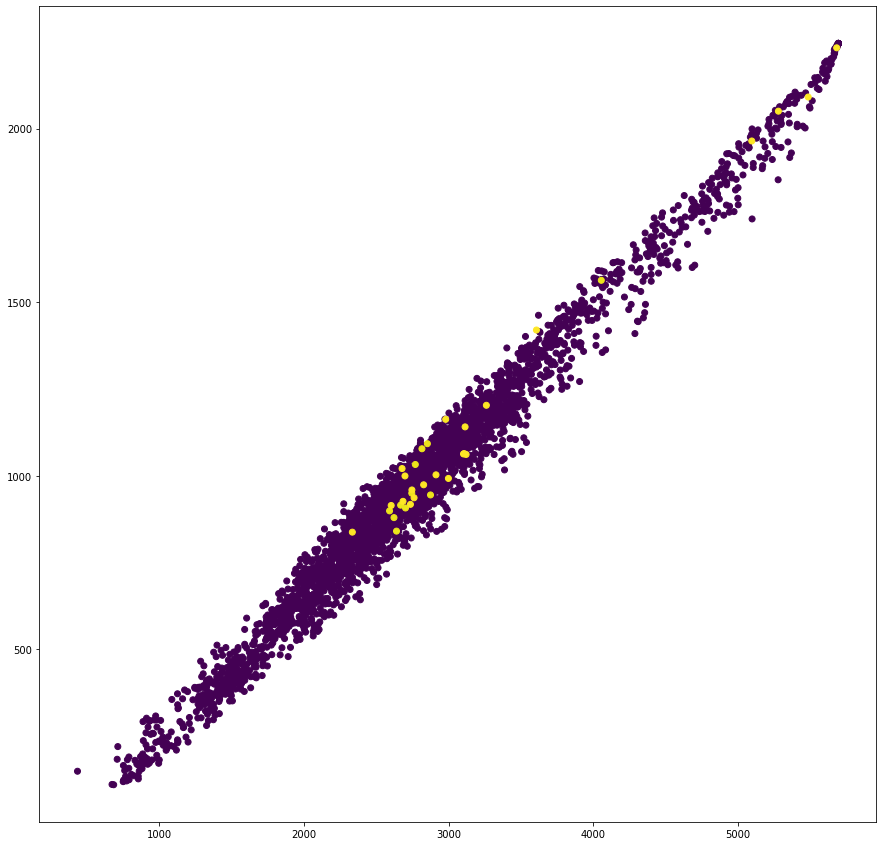

In [15]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=position_labels)

1D Array mit Anzahl der Wavesets pro Song:

In [16]:
num_of_ws_per_song = np.load("data/numOfWs.npy")
num_of_ws_per_song.shape
print(num_of_ws_per_song)

[315  20  83 236 146 288  60 157 176  38  21  28  72  99  71  68 211  37
  55  23 482  93  89 421]


### Save Data
Save every 2D song representation in seperate .txt on disk for later use.

In [28]:
for i in range(0, len(num_of_ws_per_song)):
    song_orders = [latent_representation[num_of_ws_per_song[0:i].sum():num_of_ws_per_song[0:i+1].sum(), :]]
    filename = "data/song_orders/song%d_orders.txt" % (i)
    with open(filename, "wb") as fp:
        pickle.dump(song_orders, fp)

The data should be loaded like this:

In [45]:
for i in range(0, len(num_of_ws_per_song)):
    filename = "data/song_orders/song%d_orders.txt" % (i)
    with open(filename, "rb") as fp:
        globals()["song_order%s" %i] = pickle.load(fp)
    globals()["song_order%s" %i] = np.array(globals()["song_order%s" %i])

print(song_order23.shape)

(1, 421, 2)
